# Bias-variance tradeoff 

In [1]:
import numpy as np
import pandas as pd

from pandas import Series
from pandas import DataFrame

from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Train two classifiers on a relatively large dataset 

We consider here a relatively simple prediction task with a relatively small feature set and an impossible prediction task with the same feature set for comparison.

In [2]:
sampler_0 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([0, 0])))
sampler_1 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([10, 10])))

Again use majority voting and logistic regression as classifiers to compare.

In [3]:
train = sampler_0(100)
features = list(train.columns.values[:-1])
clf_1 = MajorityVoting(features)
clf_1.fit(train, train['y'])
clf_2 = LogisticRegression(solver = 'lbfgs')
clf_2.fit(train[features], train['y'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Simple test run to see that all functions are correctly defined:

In [4]:
print('MV training error: {:.2f}%'.format(empirical_risk(clf_1, train[features], train['y'])))
print('LR training error: {:.2f}%'.format(empirical_risk(clf_2, train[features], train['y'])))

MV training error: 8.00%
LR training error: 39.00%


## II. Measuring training and test error on different dataset sizes

### Configuration and template for data collection for an impossible task

In [5]:
k = 100
sizes = [5, 25, 125, 625]

result = (combine_categories({'size': sizes, 'method': ['MV', 'LR'], 'type': ['training', 'test'], 'experiment': list(range(k))})
         .assign(error = np.nan)
         .set_index(['size', 'method', 'type', 'experiment'])
         .sort_index())
head(result)

error
size method type experiment       
5    LR     test 0             NaN
                 1             NaN
                 2             NaN
                 3             NaN
                 4             NaN

### Experiment

In [8]:
from tqdm.notebook import trange, tqdm_notebook

features = list(sampler_0(1).columns.values[:-1])
for size in sizes:
    for experiment in trange(k, desc = 'Size: {:_>4}'.format(size)):
        
        train = sampler_0(size)
        test = sampler_0(size)
        clf_1.fit(train[features], train['y'])
        result.loc[(size, 'MV', 'training', experiment), 'error'] = empirical_risk(clf_1, train[features], train['y'])
        result.loc[(size, 'MV', 'test',  experiment), 'error'] = empirical_risk(clf_1, test[features], test['y'])

        try:
            clf_2.fit(train[features], train['y'])
        except:
            continue

        result.loc[(size, 'LR', 'training', experiment), 'error'] = empirical_risk(clf_2, train[features], train['y'])
        result.loc[(size, 'LR', 'test', experiment), 'error'] = empirical_risk(clf_2, test[features], test['y'])
        
        
tail(result.sort_index().unstack(['method', 'type'])) 

error                         
method              LR              MV         
type              test training   test training
size experiment                                
625  95          51.52    42.88  51.20    24.48
     96          48.64    48.00  48.32    26.72
     97          48.96    45.44  46.24    28.00
     98          49.12    48.00  51.04    26.40
     99          49.76    46.24  49.92    25.28

### Visualisation of training and test errors

In [9]:
from pandas.api.types import CategoricalDtype
SizeType = CategoricalDtype(sizes, ordered = True)
TypeType = CategoricalDtype(['training', 'test'], ordered = True)
df = (result.reset_index()
      .assign(size = lambda df: df['size'].astype(SizeType))
      .assign(type = lambda df: df['type'].astype(TypeType))
      .pipe(lambda df: df.loc[~df['error'].isna(), :])
      .assign(risk = 50))
    
df.to_csv('results/training_bias.csv', index = False)
head(df)

,size,method,type,experiment,error,risk
0,5,LR,test,0,60.0,50
1,5,LR,test,1,80.0,50
2,5,LR,test,2,100.0,50
3,5,LR,test,3,60.0,50
4,5,LR,test,4,40.0,50


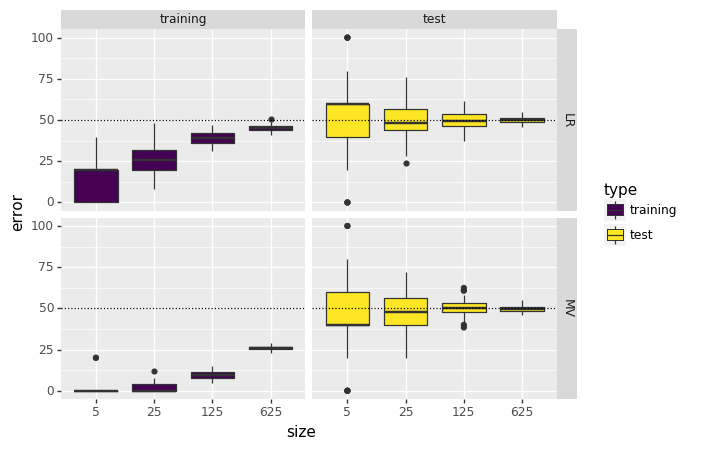

<ggplot: (7015932890)>

In [10]:
p = ggplot(data = df)
p = p + geom_boxplot(aes(x ='size', y = 'error', fill = 'type'))
p = p + geom_hline(aes(yintercept ='risk'), linetype = ':')
p = p + facet_grid(['method', 'type']) 
p.save('training_bias_1.pdf', path='results', height=6, width=12, verbose=False)
display(p)

### Visualising optimism

Let's choose experiments with test and training errors and compute the difference between them: 
$$\Delta = error_{test}-error_{train}$$

In [11]:
df = (result.unstack('type').reset_index()
      .assign(size = lambda df: df['size'].astype(SizeType))
      .assign(optimism = lambda df: df[('error','test')] - df[('error','training')])
      .pipe(lambda df: df.loc[~df['optimism'].isna(), ['size', 'method', 'experiment','optimism']]))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(mean_optimism = lambda df:df['optimism'].mean()))

df.columns = df.columns.droplevel(1)
head(df)

,size,method,experiment,optimism,mean_optimism
0,5,LR,0,40.0,40.6
1,5,LR,1,80.0,40.6
2,5,LR,2,80.0,40.6
3,5,LR,3,60.0,40.6
4,5,LR,4,20.0,40.6


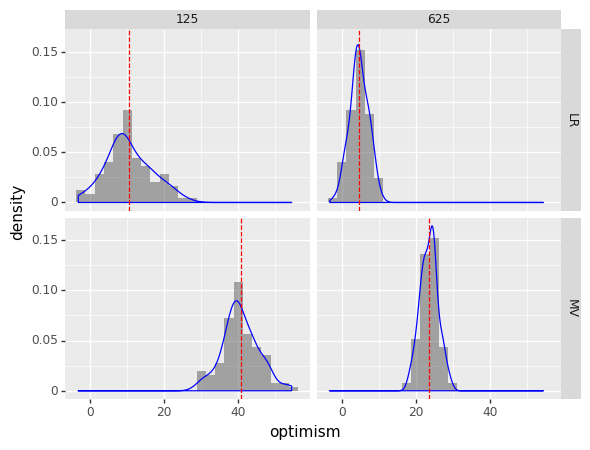

<ggplot: (7016793187)>

In [12]:
p = ggplot(df.loc[df['size'].isin([125, 625]),:])
p = p + geom_histogram(aes(x = 'optimism', y = '..density..'), binwidth=2.5, alpha=0.5)
p = p + geom_density(aes(x = 'optimism'), color="blue")
p = p + geom_vline(aes(xintercept = 'mean_optimism'), color = 'red', linetype = '--')
p = p + facet_grid(['method', 'size'])
p.save('training_bias_2.pdf', path='results', height=6, width=12, verbose=False)
display(p)

### Visualising correlation between training error and optimism

In [13]:
df = (result.unstack('type').reset_index()
      .assign(size = lambda df: df['size'].astype(SizeType))
      .assign(optimism = lambda df: df[('error','test')] - df[('error','training')])
      .assign(training = lambda df: df[('error','training')])
      .pipe(lambda df: df.loc[~df['optimism'].isna(), ['size', 'method', 'experiment', 'training', 'optimism']]))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(mean_optimism = lambda df:df['optimism'].mean()))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(mean_training = lambda df:df['training'].mean()))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(cor_training = lambda df:df['training'] + df['mean_optimism']))

df.columns = df.columns.droplevel(1)
head(df)

,size,method,experiment,optimism,training,mean_optimism,mean_training,cor_training
0,5,LR,0,40.0,20.0,40.6,10.4,60.6
1,5,LR,1,80.0,0.0,40.6,10.4,40.6
2,5,LR,2,80.0,20.0,40.6,10.4,60.6
3,5,LR,3,60.0,0.0,40.6,10.4,40.6
4,5,LR,4,20.0,20.0,40.6,10.4,60.6


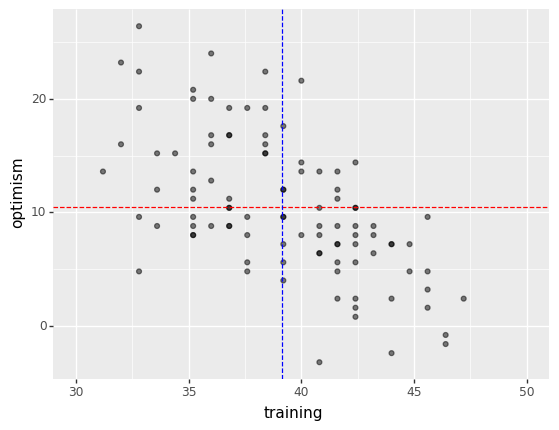

<ggplot: (7015936183)>

In [14]:
p = ggplot(df.loc[(df['size'] == 125) & (df['method'] == 'LR'),:])
p = p + geom_point(aes(x='training', y='optimism'), alpha=0.5)
p = p + geom_hline(aes(yintercept = 'mean_optimism'), color = 'red', linetype = '--')
p = p + geom_vline(aes(xintercept = 'mean_training'), color = 'blue', linetype = '--')
p = p + xlim(30,50)
p.save('training_bias_3.pdf', path='results', height=6, width=12, verbose=False)
display(p)

## III. Measuring training and test error when the data size is fixed

Normally, you have a fixed budget of data samples that you have to split into test and training sets by yourself. 
There are tradeoffs:

* Allocating too many samples to the training set makes the test error estimate unreliable.
* Not allocating enough samples to the training set makes it hard to train the model.

### Configuration and template for data collection for an impossible task

In [15]:
k = 100
size = 125
training_sizes = list(range(10, size, 10))
features = list(sampler_0(1).columns.values[:-1])


result = (combine_categories({'training_size': training_sizes, 'method': ['MV', 'LR'], 'type': ['training', 'test'], 'experiment': list(range(k))})
         .assign(size = size, error = np.nan)
         .set_index(['size', 'method', 'training_size', 'type', 'experiment'])
         .sort_index())
head(result)

error
size method training_size type experiment       
125  LR     10            test 0             NaN
                               1             NaN
                               2             NaN
                               3             NaN
                               4             NaN

### Experiment

In [16]:
from tqdm import tqdm

for training_size in tqdm_notebook(training_sizes, desc = 'Holdout sizes'):
    
    for experiment in range(k):
    
        data = sampler_0(size)
        train = data.iloc[:training_size]
        test = data.iloc[training_size:]
    
        clf_1.fit(train[features], train['y'])    
        result.loc[(size, 'MV', training_size, 'training', experiment), 'error'] = empirical_risk(clf_1, train[features], train['y'])
        result.loc[(size, 'MV', training_size, 'test', experiment), 'error'] = empirical_risk(clf_1, test[features], test['y'])
    
        try:
            clf_2.fit(train[features], train['y'])
        except:
            continue
        
        result.loc[(size, 'LR', training_size, 'training', experiment), 'error'] = empirical_risk(clf_2, train[features], train['y'])
        result.loc[(size, 'LR', training_size, 'test', experiment), 'error'] = empirical_risk(clf_2, test[features], test['y'])
    
head(result.unstack('type'))  


error         
type                                       test training
size method training_size experiment                    
125  LR     10            0           41.739130     10.0
                          1           51.304348      0.0
                          2           48.695652     10.0
                          3           47.826087     20.0
                          4           53.043478     20.0

### Visualisation

In [17]:
TrSizeType = CategoricalDtype(categories=training_sizes, ordered=True)
MethodType = CategoricalDtype(categories=['LR', 'MV'], ordered=True)

df = (result.reset_index()
      .assign(training_size = lambda df: df['training_size'].astype(TrSizeType))
      .assign(type = lambda df: df['type'].astype(TypeType))
      .assign(method = lambda df: df['method'].astype(MethodType))
     )

sdf = (df.groupby(['size', 'method', 'training_size', 'type'])
       .mean()[['error']]
       .reset_index())

In [18]:
p = ggplot(data = df) 
p = p + geom_violin(aes(x = 'training_size', y = 'error', fill='type'))
p = p + geom_point(aes(x = 'training_size', y = 'error'), data = sdf)
p = p + geom_line(aes(x = 'training_size', y = 'error'), group = 1, data = sdf)
p = p + facet_grid(['method', 'type'])
p.save('bias_variance_dilemma_0.pdf', path='results', height=6, width=12, verbose=False)
display(p)

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

### Same experiment with a different dataset 

error         
type                                       test training
size method training_size experiment                    
125  LR     10            0           26.086957      0.0
                          1           45.217391     20.0
                          2           32.173913      0.0
                          3           46.956522      0.0
                          4           39.130435      0.0

/anaconda3/envs/machine-learning/lib/python3.6/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in true_divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: invalid value encountered in true_divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarn

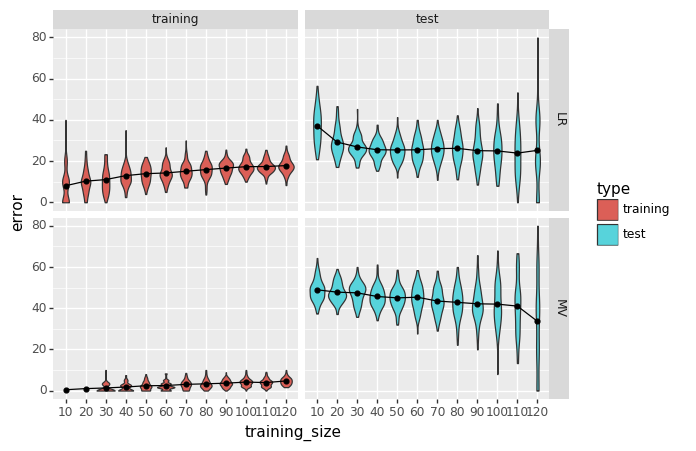

<ggplot: (-9223372029308699227)>

In [189]:
result.loc[:, 'error'] = np.nan

for training_size in tqdm_notebook(training_sizes, desc = 'Holdout sizes'):
    
    for experiment in range(k):
    
        data = sampler_1(size)
        train = data.iloc[:training_size]
        test = data.iloc[training_size:]
    
        clf_1.fit(train[features], train['y'])    
        result.loc[(size, 'MV', training_size, 'training', experiment), 'error'] = empirical_risk(clf_1, train[features], train['y'])
        result.loc[(size, 'MV', training_size, 'test', experiment), 'error'] = empirical_risk(clf_1, test[features], test['y'])
    
        try:
            clf_2.fit(train[features], train['y'])
        except:
            continue
        
        result.loc[(size, 'LR', training_size, 'training', experiment), 'error'] = empirical_risk(clf_2, train[features], train['y'])
        result.loc[(size, 'LR', training_size, 'test', experiment), 'error'] = empirical_risk(clf_2, test[features], test['y'])
    
display(head(result.unstack('type')))

df = (result.reset_index()
      .assign(training_size = lambda df: df['training_size'].astype(TrSizeType))
      .assign(type = lambda df: df['type'].astype(TypeType))
      .assign(method = lambda df: df['method'].astype(MethodType))
     )

sdf = (df.groupby(['size', 'method', 'training_size', 'type'])
       .mean()[['error']]
       .reset_index())

p = ggplot(data = df) 
p = p + geom_violin(aes(x = 'training_size', y = 'error', fill='type'))
p = p + geom_point(aes(x = 'training_size', y = 'error'), data = sdf)
p = p + geom_line(aes(x = 'training_size', y = 'error'), group = 1, data = sdf)
p = p + facet_grid(['method', 'type'])
p.save('bias_variance_dilemma_1.pdf', path='results', height=6, width=12, verbose=False)
display(p)

# Homework

## 3.1  Bias-variance tradeoff for regression* (<font color='red'>3p</font>) 

The bias-variance tradeoff exists also for regression tasks. To see this in practice, consider a simple setup.

* **Data generation:** 
  * Generate $x\sim \texttt{scipy.stats.norm}$ and $y = x + \texttt{norm(scale=0.3)}$ for a normal regression task.
  * Generate $x\sim \texttt{scipy.stats.norm}$ and $y = \texttt{norm(scale=1)}$ for an impossible regression task.
* **Prediction**: Use [`sklearn.linear_model`](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py) to predict $y$ from $x$.
* **Loss function:** 
  * Use mean squared error [`sklearn.metrics.mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error).
  * Use normalised mean squared error [`1-sklearn.metrics.r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score) for loss function if you want to compare results on different datasets.

Repeat the simulation experiment analysis done above:

* Measure training and test errors for different dataset sizes as in step II.
* Draw corresponding boxplots for test and training error behaviour  (<font color='red'>1p</font>).
* Pick an interesting dataset size and compute the bias-variance tradeoff plots as in step III  (<font color='red'>1p</font>).
* Compute optimism and visualise its distribution and how it's correlated with the training error for both data sources.
  Interpret results (<font color='red'>1p</font>):
    * What is the difference? 
    * Why is it so?

In [2]:
from scipy.stats import norm

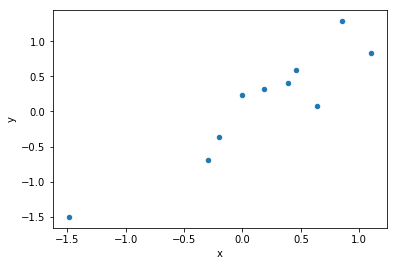

In [21]:
display(DataFrame({'x': norm.rvs(size=10)})
        .assign(y = lambda df: df['x'] + norm.rvs(size =  10,scale=0.3))
        .plot(x='x', y='y', kind='scatter'))

In [3]:
%config IPCompleter.greedy=True